In [ ]:
#최소 99.2% 이상 이미지 1개 당 prediction 시간을 보고서에 적기
#매트릭스 https://kevinmusgrave.github.io/pytorch-metric-learning/losses/

In [1]:
import os
import json
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
!pip install torchsummary
!pip install pytorch-metric-learning -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from matplotlib import pyplot as plt
%matplotlib inline

In [37]:
#gpu 사용 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [38]:
# parameters
learning_rate = 0.0001  #가중치 업데이트 정도
training_epochs = 15     #학습 데이터를 모두 사용하여 학습의 기본 단위
batch_size = 50        #모델 가중치를 한 번 업데이트할 때 사용되는 샘플 단위 개수(미니배치)

In [39]:
traintransform = transforms.Compose([
         #transforms.RandomAffine(degrees=(-45,45), translate=(0.1, 0.1)),
         #transforms.ColorJitter(brightness=0.5,contrast=0.5),                             
         transforms.ToTensor(), 
         #transforms.Normalize(mean=(0.5,), std=(0.5,))                              
]) 

testtransform = transforms.Compose([                            
         transforms.ToTensor(), 
         #transforms.Normalize(mean=(0.5,), std=(0.5,))                              
]) 


In [40]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          #transform=transforms.ToTensor(),
                          transform=traintransform,
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=testtransform,
                         download=True)

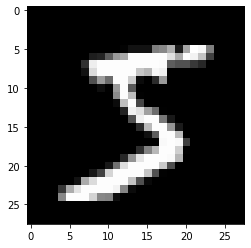

In [41]:
image, label = mnist_train[0]
plt.imshow(image.squeeze().numpy(), cmap='gray')


In [42]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [14]:
# CNN Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)                                 #들어오는 이미지 28x28 채널1 
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  #입력채널 1, 출력채널 32, 커널 3x3,  stride=1 padding 1
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        

        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        

        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [15]:
import torchsummary
model = CNN().to(device)
torchsummary.summary(model, (1, 28, 28))          #ouputshape 채널, 이미지 사이즈 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 7, 7]          73,856
      BatchNorm2d-10            [-1, 128, 7, 7]             256
             ReLU-11            [-1, 128, 7, 7]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                  [-1, 625]       1,280,625
           Linear-14                  [

In [ ]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train my model
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. It takes sometime.')

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.238257125
[Epoch:    2] cost = 0.0691493228
[Epoch:    3] cost = 0.0508465283
[Epoch:    4] cost = 0.0402199216
[Epoch:    5] cost = 0.0323683843
[Epoch:    6] cost = 0.0276454035
[Epoch:    7] cost = 0.0239786562
[Epoch:    8] cost = 0.0201297887
[Epoch:    9] cost = 0.0182850249
[Epoch:   10] cost = 0.0156777985
[Epoch:   11] cost = 0.0147101376
[Epoch:   12] cost = 0.0122384094
[Epoch:   13] cost = 0.0126536759
[Epoch:   14] cost = 0.00956484303
[Epoch:   15] cost = 0.0105420789
Learning Finished!


In [ ]:
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9896000027656555


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [10]:
import torchvision.models as model #torchvision에서 제공하는 모델을 바로 사용할 때 
import torch.nn as nn
import torch.nn.functional as F

In [11]:
model= model.resnet18(True)
model.conv1= nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc= nn.Linear(num_ftrs,10)
model.to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train my model
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. It takes sometime.')

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Learning started. It takes sometime.
[Epoch:    1] cost = 0.26493147
[Epoch:    2] cost = 0.080604963
[Epoch:    3] cost = 0.0532042384
[Epoch:    4] cost = 0.0418603122
[Epoch:    5] cost = 0.0306973774
[Epoch:    6] cost = 0.0280082729
[Epoch:    7] cost = 0.0223951843
[Epoch:    8] cost = 0.0189540293
[Epoch:    9] cost = 0.0179847199
[Epoch:   10] cost = 0.0144471694
[Epoch:   11] cost = 0.0146048181
[Epoch:   12] cost = 0.0115003502
[Epoch:   13] cost = 0.0119084185
[Epoch:   14] cost = 0.0094242692
[Epoch:   15] cost = 0.0101599973
Learning Finished!


In [12]:
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9889999628067017


In [16]:
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 7, 7]          73,856
      BatchNorm2d-10            [-1, 128, 7, 7]             256
             ReLU-11            [-1, 128, 7, 7]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                  [-1, 625]       1,280,625
           Linear-14                  [

In [20]:
#다른 loss로 바꾸어보기 
#TripletMarginLoss
import torchvision.models as model #torchvision에서 제공하는 모델을 바로 사용할 때 
import torch.nn as nn
import torch.nn.functional as F

model= model.resnet18(True)
model.conv1= nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc= nn.Linear(num_ftrs,10)
model.to(device)

criterion = losses.TripletMarginLoss().to(device)    # margin=0.1일때 0.0843999981880188
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train my model
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. It takes sometime.')

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.0921615884
[Epoch:    2] cost = 0.0649312958
[Epoch:    3] cost = 0.0563098378
[Epoch:    4] cost = 0.0503750183
[Epoch:    5] cost = 0.0453439578
[Epoch:    6] cost = 0.0411263667
[Epoch:    7] cost = 0.0378665626
[Epoch:    8] cost = 0.0349130146
[Epoch:    9] cost = 0.0315073952
[Epoch:   10] cost = 0.029067101
[Epoch:   11] cost = 0.0269100927
[Epoch:   12] cost = 0.0265604947
[Epoch:   13] cost = 0.0232910048
[Epoch:   14] cost = 0.0225575492
[Epoch:   15] cost = 0.0202386472
Learning Finished!


In [21]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.0973999947309494


In [43]:
#다른 loss로 바꾸어보기 
#ArcFaceLoss
import torchvision.models as model #torchvision에서 제공하는 모델을 바로 사용할 때 
import torch.nn as nn
import torch.nn.functional as F

model= model.resnet18(True)
model.conv1= nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc= nn.Linear(num_ftrs, 128)
model.to(device)

criterion = losses.ArcFaceLoss(num_classes=10, embedding_size=128).to(device)    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train my model
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. It takes sometime.')

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 5.34232569
[Epoch:    2] cost = 1.66924608
[Epoch:    3] cost = 1.21878004
[Epoch:    4] cost = 0.989615798
[Epoch:    5] cost = 0.825773895
[Epoch:    6] cost = 0.644788504
[Epoch:    7] cost = 0.623094201
[Epoch:    8] cost = 0.555002868
[Epoch:    9] cost = 0.528921723
[Epoch:   10] cost = 0.470124841
[Epoch:   11] cost = 0.404031068
[Epoch:   12] cost = 0.379038543
[Epoch:   13] cost = 0.358700395
[Epoch:   14] cost = 0.323501706
[Epoch:   15] cost = 0.29419294
Learning Finished!


In [46]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.0


In [44]:
#다른 loss로 바꾸어보기 
#AngularLoss
import torchvision.models as model #torchvision에서 제공하는 모델을 바로 사용할 때 
import torch.nn as nn
import torch.nn.functional as F

model= model.resnet18(True)
model.conv1= nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc= nn.Linear(num_ftrs, 10)
model.to(device)

criterion = losses.AngularLoss().to(device)    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train my model
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. It takes sometime.')

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

In [44]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())